### Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

### Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Taxi_Fare_Prediction/train.csv', nrows=1000000, parse_dates=['pickup_datetime'],
date_parser=pd.to_datetime)
train_data = data.copy()

In [4]:
train_data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
test_data = pd.read_csv('/content/drive/MyDrive/Taxi_Fare_Prediction/test.csv', parse_dates=['pickup_datetime'],
date_parser=pd.to_datetime)
test_data

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


### Explore Data

In [6]:
train_data.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [7]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


### Missing value

In [8]:
total = train_data.isna().sum().sort_values(ascending = False)
percent = (train_data.isna().sum()/train_data.shape[0]).sort_values(ascending = False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


,Total,Percent
dropoff_latitude,10,0.00001
dropoff_longitude,10,0.00001
passenger_count,0,0.00000
pickup_latitude,0,0.00000
pickup_longitude,0,0.00000
pickup_datetime,0,0.00000
fare_amount,0,0.00000
key,0,0.00000


As we can see, there are 10 missing values in droo off latitude and longitude. I am gonna delete them all

In [9]:
train_data = train_data.dropna()

In [10]:
# delete all the instance with all locations is 0
train_data = train_data[(train_data.pickup_longitude != 0) & (train_data.pickup_latitude != 0) & (train_data.dropoff_longitude != 0) & (train_data.dropoff_latitude != 0)]

In [11]:
train_data.shape


(980325, 8)

### Handling outliers

In [12]:
train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,980325.000000,980325.000000,980325.000000,980325.000000,980325.000000,980325.000000
mean,11.332722,-73.914357,40.694570,-73.918986,40.683223,1.685283
std,9.748663,6.644248,4.255156,5.281498,6.125452,1.308030
min,-44.900000,-3377.680935,-880.627428,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992267,40.736527,-73.991568,40.735513,1.000000
50%,8.500000,-73.982076,40.753387,-73.980576,40.753845,1.000000
75%,12.500000,-73.968273,40.767567,-73.965260,40.768412,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,6.000000


The Interval of latitude and longitude in NY is **[40.4772, 45.0153]** and **[-79.7624, -71.7517]** respectively 


In [13]:
train_data = train_data[(train_data['pickup_latitude'] > 40.4772) & (train_data['pickup_latitude'] < 45.0153)]
train_data = train_data[(train_data['dropoff_latitude'] > 40.4772) & (train_data['dropoff_latitude'] < 45.0153)]
train_data = train_data[(train_data['pickup_longitude'] > -79.7624) & (train_data['pickup_longitude'] < -71.7517)]
train_data = train_data[(train_data['dropoff_longitude'] > -79.7624) & (train_data['dropoff_longitude'] < -71.7517)]

In [14]:
train_data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### Feature Extraction

In [15]:
# Calculate the distance of travel
def haversine_distance(data):

    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(data['pickup_latitude'])
    phi2 = np.radians(data['dropoff_latitude'])
    
    delta_phi = np.radians(data['dropoff_latitude']-data['pickup_latitude'])
    delta_lambda = np.radians(data['dropoff_longitude']-data['pickup_longitude'])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    #d = R*c
    d = (R * c) #in kilometers
    data['H_Distance'] = d

    return data


In [16]:
def get_datetime(data):
    data['year'] = data['pickup_datetime'].dt.year.astype('category')
    data['month'] = data['pickup_datetime'].dt.month.astype('category')
    data['week'] = data['pickup_datetime'].dt.week.astype('category')
    data['dayofweek'] = data['pickup_datetime'].dt.dayofweek.astype('category')
    data['hour'] = data['pickup_datetime'].dt.hour.astype('category')
    data = data.drop(columns=['pickup_datetime', 'key'])
    return data

In [17]:
train_df = train_data.pipe(haversine_distance).pipe(get_datetime)
train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,year,month,week,dayofweek,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009,6,25,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010,1,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011,8,33,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012,4,16,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010,3,10,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7.0,-73.976676,40.785630,-73.959196,40.775114,1,1.879763,2014,9,37,5,21
999996,7.3,-73.992103,40.671385,-73.992103,40.671385,2,0.000000,2010,9,38,0,14
999997,10.5,-73.978423,40.751135,-73.993397,40.762197,5,1.761741,2013,4,17,4,14
999998,6.9,-73.980317,40.759482,-73.976832,40.743122,1,1.842683,2011,7,27,4,0


In [18]:
test_df = test_data.pipe(haversine_distance).pipe(get_datetime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


### Explore target variable

In [19]:
train_df.fare_amount.describe()

count    979183.000000
mean         11.331538
std           9.738917
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

Fare amount should be greater than 0

In [20]:
#delete all instance with price less than 0
train_df = train_df[train_df['fare_amount'] > 0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


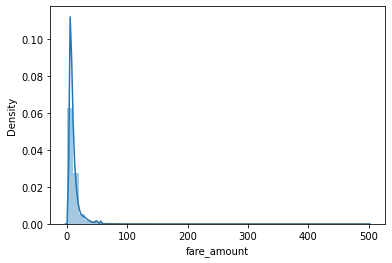

In [21]:
sns.distplot(train_df.fare_amount)

As we can see, the distribution of 'fare_amount' is right skewed. we can certainly fix it by using log trainsformation

In [22]:
train_df['fare_amount'] = np.log1p(train_df['fare_amount'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


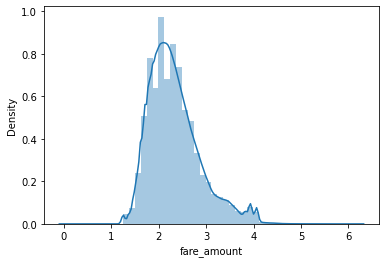

In [23]:
sns.distplot(train_df.fare_amount)

Explore Corelation between H_distance and Fare_amount

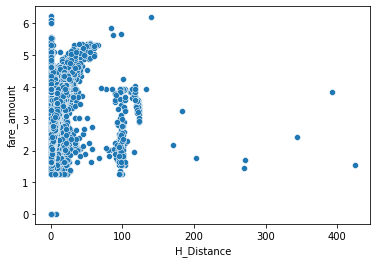

In [24]:
sns.scatterplot(x='H_Distance', y='fare_amount', data=train_df)

Delete some outliers of distance

In [25]:
train_df = train_df[train_df['H_Distance'] <140]

In [26]:
train_df.corr()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance
fare_amount,1.000000,0.276769,-0.160617,0.249022,-0.142722,0.018436,0.769715
pickup_longitude,0.276769,1.000000,0.107872,0.429992,0.116779,-0.000149,0.359072
pickup_latitude,-0.160617,0.107872,1.000000,0.132634,0.482199,-0.007993,-0.144350
dropoff_longitude,0.249022,0.429992,0.132634,1.000000,0.204365,-0.001853,0.291442
dropoff_latitude,-0.142722,0.116779,0.482199,0.204365,1.000000,-0.005146,-0.119272
passenger_count,0.018436,-0.000149,-0.007993,-0.001853,-0.005146,1.000000,0.009436
H_Distance,0.769715,0.359072,-0.144350,0.291442,-0.119272,0.009436,1.000000


As we expected, distance and fare amount have the positive correlation

### Dummy categorical variables

In [27]:
train_df = pd.get_dummies(train_df)
train_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_10,week_11,week_12,week_13,week_14,...,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1.704748,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2.884801,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1.902108,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2.163323,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.840550,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,2.079442,-73.976676,40.785630,-73.959196,40.775114,1,1.879763,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
999996,2.116256,-73.992103,40.671385,-73.992103,40.671385,2,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
999997,2.442347,-73.978423,40.751135,-73.993397,40.762197,5,1.761741,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
999998,2.066863,-73.980317,40.759482,-73.976832,40.743122,1,1.842683,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
test_df = pd.get_dummies(test_df)

## Model Building

### Split data

In [29]:
columns = list(train_df.columns)
columns.remove('fare_amount')

In [30]:
X =  train_df[columns]
y = train_df['fare_amount']

**Ridge Regression**

In [84]:
param_grid = {'alpha': [1, 10, 100],
              'normalize': [False,True],
              'tol': [0.001, 0.005],
              'solver': ['auto']}

rigde_model = GridSearchCV(Ridge(), param_grid=param_grid, cv=5, n_jobs = -1 )

In [85]:
rigde_model.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [1, 10, 100], 'normalize': [False, True],
                         'solver': ['auto'], 'tol': [0.001, 0.005]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [86]:
print(rigde_model.best_score_)
print(rigde_model.best_params_)

0.6201931999602698
{'alpha': 10, 'normalize': False, 'solver': 'auto', 'tol': 0.001}


**ElasticNet**

In [87]:
param_grid = {'alpha': [0.1, 1, 10],
              'l1_ratio': [0.5, 1],
              'normalize': [False,True],
              'tol': [0.001, 0.0001]}

ElasticNet_model = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5, n_jobs = -1 )

In [88]:
ElasticNet_model.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'l1_ratio': [0.5, 1],
                         'normalize': [False, True], 'tol': [0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [90]:
print(ElasticNet_model.best_score_)
print(ElasticNet_model.best_params_)

0.5917276269700035
{'alpha': 0.1, 'l1_ratio': 0.5, 'normalize': False, 'tol': 0.001}


**XGBoost**

In [75]:
import xgboost
xgb1 = xgboost.XGBRegressor()
parameters = {
              'learning_rate': [.01, 0.1], #so called `eta` value
              'max_depth': [5, 6],
              'n_estimators': [20]}

In [76]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

In [77]:
xgb_grid.fit(X,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 24.6min finished


[22:58:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [5, 6],
                         'n_estimators': [20]},
          

In [78]:
import pickle

In [79]:
filename = '/content/drive/MyDrive/Taxi_Fare_Prediction/xgb_model.pkl'
with open(filename, 'wb') as file:  
    pickle.dump(xgb_grid, file)

In [80]:
# Load the Model back from file
with open(filename, 'rb') as file:  
    xgb_grid = pickle.load(file)

[23:17:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [81]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.627131517362282
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 20}


In [50]:
fare_amount = xgb_reg.predict(test_df)

In [ ]:
result = test_data[['key']]
result['fare_amount'] = fare_amount
result.to_csv('/content/drive/MyDrive/Taxi_Fare_Prediction/submission.csv',index=False)